# Netlist extractor YAML

Any component can extract its netlist with `get_netlist`

While `gf.read.from_yaml` converts a `YAML Dict` into a `Component`

`get_netlist` converts `Component` into a YAML `Dict`

In [1]:
import gdsfactory as gf
import yaml

In [ ]:
c = gf.components.mzi()
c.plot()

In [ ]:
c.plot_netlist()

In [ ]:
c = gf.components.ring_single()
c.plot()

In [ ]:
c.plot_netlist()

In [ ]:
n = c.get_netlist()

In [ ]:
netlist_string = c.write_netlist(n)

In [ ]:
n = yaml.safe_load(netlist_string)

In [ ]:
i = list(n["instances"].keys())
i

In [ ]:
instance_name0 = i[0]

In [ ]:
n["instances"][instance_name0]["settings"]

## Instance names

By default get netlist names each `instance` with the name of the `reference`


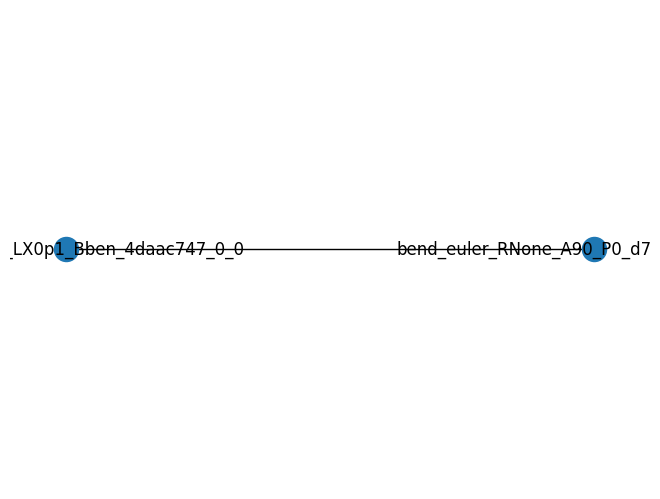

In [2]:
@gf.cell
def mzi_with_bend_automatic_naming():
    c = gf.Component()
    mzi = c.add_ref(gf.components.mzi())
    bend = c.add_ref(gf.components.bend_euler())
    bend.connect("o1", mzi.ports["o2"])
    return c


c = mzi_with_bend_automatic_naming()
c.plot_netlist()

In [3]:
@gf.cell
def mzi_with_bend_deterministic_names_using_alias():
    c = gf.Component()
    mzi = c.add_ref(gf.components.mzi(), name="my_mzi")
    bend = c.add_ref(gf.components.bend_euler(), name="my_bend")
    bend.connect("o1", mzi.ports["o2"])
    return c


c = mzi_with_bend_deterministic_names_using_alias()
c.plot_netlist()

TypeError: Component.add_ref() got an unexpected keyword argument 'alias'

In [ ]:
c = gf.components.mzi()
c.plot()

In [ ]:
c = gf.components.mzi()
n = c.get_netlist()
print(c.get_netlist().keys())

In [ ]:
c.plot_netlist()

In [ ]:
n.keys()

## warnings

Lets make a connectivity **error**, for example connecting ports on the wrong layer


In [ ]:
@gf.cell
def mmi_with_bend():
    c = gf.Component()
    mmi = c.add_ref(gf.components.mmi1x2(), name="mmi")
    bend = c.add_ref(gf.components.bend_euler(layer=(2, 0)), name="bend")
    bend.connect("o1", mmi.ports["o2"], allow_layer_mismatch=True)
    return c


c = mmi_with_bend()
c.plot()

In [ ]:
n = c.get_netlist()

In [ ]:
print(n["warnings"])

In [ ]:
c.plot_netlist()

## get_netlist_recursive

When you do `get_netlist()` for a component it will only show connections for the instances that belong to that component.
So despite having a lot of connections, it will show only the meaningful connections for that component.
For example, a ring has a ring_coupler. If you want to dig deeper, the connections that made that ring coupler are still available.

`get_netlist_recursive()` returns a recursive netlist.

In [ ]:
c = gf.components.ring_single()
c.plot()

In [ ]:
c.plot_netlist()

In [ ]:
c = gf.components.ring_double()
c.plot()

In [ ]:
c.plot_netlist()

In [ ]:
c = gf.components.mzit()
c.plot()

In [ ]:
c.plot_netlist()

In [ ]:
coupler_lengths = (10, 20, 30)
coupler_gaps = (0.1, 0.2, 0.3)
delta_lengths = (10, 100)

c = gf.components.mzi_lattice(
    coupler_lengths=coupler_lengths,
    coupler_gaps=coupler_gaps,
    delta_lengths=delta_lengths,
)
c.plot()

In [ ]:
c.plot_netlist()

In [ ]:
coupler_lengths = (10, 20, 30, 40)
coupler_gaps = (0.1, 0.2, 0.4, 0.5)
delta_lengths = (10, 100, 200)

c = gf.components.mzi_lattice(
    coupler_lengths=coupler_lengths,
    coupler_gaps=coupler_gaps,
    delta_lengths=delta_lengths,
)
c.plot()

In [ ]:
n = c.get_netlist()

In [ ]:
c.plot_netlist()

In [ ]:
n_recursive = c.get_netlist(recursive=True)

In [ ]:
n_recursive.keys()

Placement information is accumulated, and connections and ports are mapped, respectively, to the ports of the unique instances or the component top level ports. This can be plotted:

In [ ]:
c.plot_netlist(with_labels=False)  # labels get cluttered

## allow_multiple_connections

The default `get_netlist` function (also used by default by `get_netlist_recurse` and `get_netlist_flat`) can identify more than two ports sharing the same connection through the `allow_multiple` flag.

For instance, consider a resistor network with one shared node:

In [ ]:
import gdsfactory as gf

vdiv = gf.Component()
r1 = vdiv << gf.components.resistance_sheet()
r2 = vdiv << gf.components.resistance_sheet()
r3 = vdiv << gf.get_component(gf.components.resistance_sheet)
r4 = vdiv << gf.get_component(gf.components.resistance_sheet)

r1.connect("pad2", r2.ports["pad1"])
r3.connect("pad1", r2.ports["pad1"])
r4.connect("pad2", r2.ports["pad1"])

r4.drotate(90)

vdiv.plot()

In [ ]:
try:
    vdiv.get_netlist()
except Exception as exc:
    print(exc)

In [ ]:
vdiv.get_netlist(allow_multiple=True)